# Example: Deep structural causal model counterfactuals

In [1]:
%reload_ext autoreload
%autoreload 2

%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

In [2]:
from typing import Dict, List, Optional, Tuple, Union, TypeVar
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import pytorch_lightning as pl

import pyro
import pyro.distributions as dist
from pyro.poutine import condition, reparam
from pyro.nn import PyroParam, PyroSample, PyroModule
import pyro.distributions.transforms as Transforms
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDelta
from pyro.infer import config_enumerate
from pyro.distributions import constraints


import causal_pyro
from causal_pyro.query.do_messenger import do
from causal_pyro.counterfactual.handlers import Factual, MultiWorldCounterfactual, TwinWorldCounterfactual
from causal_pyro.reparam.soft_conditioning import TransformInferReparam

import pandas as pd
import skimage
import tqdm
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt

In [3]:
available = torch.cuda.is_available()
curr_device = torch.device("cpu") if not available else torch.cuda.current_device()
print(f'Cuda available: {available}')
print(f'Current device: {curr_device}')

if available:
    device_count = torch.cuda.device_count() 
    device_name =  torch.cuda.get_device_name(0)
    print(f'Device count: {device_count}')
    print(f'Device name: {device_name}')

Cuda available: True
Current device: 0
Device count: 1
Device name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


## Background: Normalizing flows and counterfactuals

Much of the causal inference literature has focused on relatively simple
causal models with low dimensional data. In order to perform
counterfactual reasoning in more complex domains with high dimensional
data, Palowski et al. [@pawlowski2020deep] introduced *deep structural
causal models* (Deep SCMs): SCMs with neural networks as the functional
mechanisms between variables.

Specifically, the neural networks are
*normalizing flows*. A normalizing flow transforms a base probability
distribution (often a simple distribution, such as a multivariate
Gaussian) through a sequence of invertible transformations into a more
complex distribution (such as a distribution over images). When used
within a Deep SCM, the flow's base distribution is an exogenous noise
variable, and its output is an endogenous variable.

A salient property
of normalizing flows is that computing the likelihood of data can be
done both exactly and efficiently, and hence training a flow to model a
data distribution through maximum likelihood is straightforward. In
addition, the inverse of a normalizing flow can also typically be
efficiently computed, which renders the abduction step of a
counterfactual---inferring the posterior over exogenous variables given
evidence---trivial.

## Example: Morpho-MNIST

We consider a synthetic dataset based on MNIST, where the image of each digit ($X$) depends on stroke thickness ($T$) and brightness ($I$) of the image and the thickness depends on brightness as well.

We assume we know full causal structure (i.e., there are no unconfounded variables).

In [4]:
def load_idx(path: str) -> np.ndarray:
    with (gzip.open(path, 'rb') if path.endswith('.gz') else open(path, 'rb')) as f:
        idx_dtype, ndim = struct.unpack('BBBB', f.read(4))[2:]
        shape = struct.unpack('>' + 'I' * ndim, f.read(4 * ndim))
        buffer_length = int(np.prod(shape))
        return np.frombuffer(f.read(buffer_length), dtype=np.uint8).reshape(shape).astype(np.float32)
    
path = os.path.join(os.getcwd(), "../datasets/morphomnist/")
raw_labels = load_idx(path+"train-labels-idx1-ubyte.gz")
raw_images = load_idx(path+"train-images-idx3-ubyte.gz")
raw_metrics = pd.read_csv(path + "train-morpho.csv", index_col= 'index')
raw_thickness = raw_metrics["thickness"]
raw_intensity = raw_metrics["intensity"]

reduced_images = skimage.measure.block_reduce(raw_images, block_size=(1, 2, 2))

im_size = reduced_images.shape[-1]
thickness_size = 1
intensity_size = 1

digit = 5
indices = raw_labels == digit

images = torch.tensor(reduced_images[np.broadcast_to(indices[..., None, None], reduced_images.shape)].reshape(-1, *reduced_images.shape[-2:]), dtype=torch.float32).requires_grad_(False)
labels = torch.tensor(raw_labels[indices], dtype=torch.float32).requires_grad_(False)
thickness = torch.tensor(raw_metrics["thickness"][indices], dtype=torch.float32).requires_grad_(False)
intensity = torch.tensor(raw_metrics["intensity"][indices], dtype=torch.float32).requires_grad_(False)

(-0.5, 13.5, 13.5, -0.5)

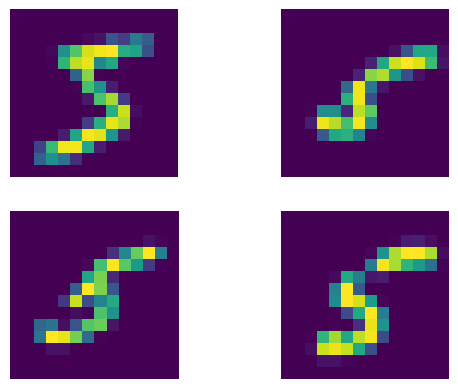

In [5]:
fig = plt.figure()
rows = 2
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(images[0].cpu())
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(images[1].cpu())
plt.axis('off')
fig.add_subplot(rows, columns, 3)
plt.imshow(images[2].cpu())
plt.axis('off')
fig.add_subplot(rows, columns, 4)
plt.imshow(images[3].cpu())
plt.axis('off')

## Model: deep structural causal model

The following code models morphological transformations of MNIST,
defining a causal generative model over digits that contains endogenous
variables to control the width $t$ and intensity $i$ of the stroke:

In [6]:
class ConstantParamTransformModule(dist.torch_transform.TransformModule):
    def __init__(self, transform: Transforms.Transform):
        super().__init__()
        self._transform = transform
        self.domain = transform.domain
        self.codomain = transform.codomain
        self.bijective = transform.bijective
        
    @property
    def sign(self):
        return self._transform.sign
        
    def _call(self, x):
        return self._transform(x)
    
    def _inverse(self, y):
        return self._transform.inv(y)
    
    def log_abs_det_jacobian(self, x, y):
        return self._transform.log_abs_det_jacobian(x, y)


class ComposeTransformModule(Transforms.ComposeTransformModule):
    def __init__(self, transforms: List[Transforms.Transform]):
        super().__init__([
            ConstantParamTransformModule(t) if not isinstance(t, torch.nn.Module) else t for t in transforms
        ])
        # for parameter storage...
        self._part_modules = torch.nn.ModuleList(self.parts)


class ConditionalComposeTransformModule(dist.conditional.ConditionalTransformModule):
    def __init__(self, transforms: List):
        self.transforms = [
            dist.conditional.ConstantConditionalTransform(t)
            if not isinstance(t, dist.conditional.ConditionalTransform)
            else t
            for t in transforms
        ]
        super().__init__()
        # for parameter storage...
        self._transforms_module = torch.nn.ModuleList([t for t in transforms if isinstance(t, torch.nn.Module)])

    def condition(self, context: torch.Tensor):
        return ComposeTransformModule([t.condition(context) for t in self.transforms])

In [7]:
class ConcatELU(torch.nn.Module):
    """
    Activation function that applies ELU in both direction (inverted and plain).
    Allows non-linearity while providing strong gradients for any input (important for final convolution)
    """
    def forward(self, x):
        return torch.cat([torch.nn.functional.elu(x), torch.nn.functional.elu(-x)], dim=-3)


class LayerNormChannels(torch.nn.Module):

    def __init__(self, c_in: int, eps: float = 1e-5):
        """
        This module applies layer norm across channels in an image.
        Inputs:
            c_in - Number of channels of the input
            eps - Small constant to stabilize std
        """
        super().__init__()
        self.gamma = torch.nn.Parameter(torch.ones(1, c_in, 1, 1))
        self.beta = torch.nn.Parameter(torch.zeros(1, c_in, 1, 1))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=-3, keepdim=True)
        var = x.var(dim=-3, unbiased=False, keepdim=True)
        y = (x - mean) / torch.sqrt(var + self.eps)
        y = y * self.gamma + self.beta
        return y


class GatedConv(torch.nn.Module):

    def __init__(self, c_in: int, c_hidden: int):
        """
        This module applies a two-layer convolutional ResNet block with input gate
        Inputs:
            c_in - Number of channels of the input
            c_hidden - Number of hidden dimensions we want to model (usually similar to c_in)
        """
        super().__init__()
        self.net = torch.nn.Sequential(
            ConcatELU(),
            torch.nn.Conv2d(2*c_in, c_hidden, kernel_size=3, padding=1),
            ConcatELU(),
            torch.nn.Conv2d(2*c_hidden, 2*c_in, kernel_size=1)
        )

    def forward(self, x):
        out = self.net(x)
        val, gate = out.chunk(2, dim=-3)
        return x + val * torch.sigmoid(gate)


class GatedConvNet(torch.nn.Module):

    def __init__(self, c_in: int, c_hidden: int, num_layers: int, eps: float = 1e-5):
        """
        Module that summarizes the previous blocks to a full convolutional neural network.
        Inputs:
            c_in - Number of input channels
            c_hidden - Number of hidden dimensions to use within the network
            c_out - Number of output channels. If -1, 2 times the input channels are used (affine coupling)
            num_layers - Number of gated ResNet blocks to apply
        """
        super().__init__()
        c_out = 2 * c_in
        layers = []
        layers += [torch.nn.Conv2d(c_in, c_hidden, kernel_size=3, padding=1)]
        for layer_index in range(num_layers):
            layers += [
                GatedConv(c_hidden, c_hidden),
                LayerNormChannels(c_hidden, eps=eps)
            ]
        layers += [
            ConcatELU(),
            torch.nn.Conv2d(2*c_hidden, c_out, kernel_size=3, padding=1)
        ]
        self.nn = torch.nn.Sequential(*layers)

        self.nn[-1].weight.data.zero_()
        self.nn[-1].bias.data.zero_()

    def forward(self, x):
        return self.nn(x)

class MaskedAffineCoupling(dist.torch_transform.TransformModule):
    bijective = True
    domain = constraints.independent(constraints.real, 3)
    codomain = constraints.independent(constraints.real, 3)

    def __init__(self, network: torch.nn.Module, mask: torch.Tensor, c_in: int, h: int, w: int):
        """
        Coupling layer inside a normalizing flow.
        Inputs:
            network - A PyTorch nn.Module constituting the deep neural network for mu and sigma.
                      Output shape should be twice the channel size as the input.
            mask - Binary mask (0 or 1) where 0 denotes that the element should be transformed,
                   while 1 means the latent will be used as input to the NN.
            c_in - Number of input channels
        """
        self.c_in = c_in
        self.h = h
        self.w = w
        super().__init__()
        self.network = network
        self.scaling_factor = torch.nn.Parameter(torch.zeros(c_in, device=mask.device))
        self.register_buffer('mask', mask)
        
    def log_abs_det_jacobian(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        nn_out = self.network(x * self.mask)
        s, t = nn_out.chunk(2, dim=-3)
        s_fac = self.scaling_factor.exp().view(1, -1, 1, 1)
        s = torch.tanh(s / s_fac) * s_fac
        s = s * (1 - self.mask)
        return s.sum(dim=[-1,-2,-3])
    
    def _inverse(self, y: torch.Tensor) -> torch.Tensor:
        # get hold of x by masking transformed parts of y
        nn_out = self.network(y * self.mask)
        s, t = nn_out.chunk(2, dim=-3)

        # Stabilize scaling output
        s_fac = self.scaling_factor.exp().view(1, -1, 1, 1)
        s = torch.tanh(s / s_fac) * s_fac

        # Mask outputs (only transform the second part)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)

        # Affine transformation
        return (y * torch.exp(-s)) - t
    
    def _call(self, x: torch.Tensor) -> torch.Tensor:
        nn_out = self.network(x * self.mask)
        s, t = nn_out.chunk(2, dim=-3)

        # Stabilize scaling output
        s_fac = self.scaling_factor.exp().view(1, -1, 1, 1)
        s = torch.tanh(s / s_fac) * s_fac

        # Mask outputs (only transform parts where self.mask == 0)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)

        # Affine transformation
        return (x + t) * torch.exp(s)

In [8]:
class ThicknessTransform(ComposeTransformModule):
    def __init__(self, thickness_size: int, weight: torch.Tensor, bias: torch.Tensor):
        self.thickness_size = thickness_size
        super().__init__([
            Transforms.Spline(thickness_size),
            Transforms.AffineTransform(loc=bias, scale=weight, event_dim=0),
            Transforms.ExpTransform()
        ])


class IntensityTransform(ConditionalComposeTransformModule):
    def __init__(self, intensity_size: int, thickness_size: int, hidden_dims: List[int], weight: torch.Tensor, bias: torch.Tensor):
        self.intensity_size = intensity_size
        self.thickness_size = thickness_size
        self.hidden_dims = hidden_dims
        intensity_nn = pyro.nn.DenseNN(
            thickness_size,
            hidden_dims,
            param_dims=[intensity_size, intensity_size],
            nonlinearity=torch.nn.ReLU()
        )
        super().__init__([
            ConditionalAffineTransform(intensity_nn, event_dim=0),
            Transforms.SigmoidTransform(),
            Transforms.AffineTransform(loc=bias, scale=weight, event_dim=0),
        ])


class ImageTransform(ConditionalComposeTransformModule):
    def __init__(
        self,
        im_size: int,
        input_channels: int,
        thickness_size: int,
        intensity_size: int,
        num_blocks: int,
        layers_per_block: int,
        hidden_channels: int,
        *,
        alpha: float = 1e-5,
        bn_momentum: float = 0.05,
        ln_momentum: float = 1e-5,
        nonlinearity = torch.nn.ReLU(),
    ):
        self.im_size = im_size
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.num_blocks = num_blocks
        self.layers_per_block = layers_per_block
        
        self.flat_input_size = input_channels * im_size * im_size
        
        layers = []

        preprocess_transform = Transforms.ComposeTransform([
            Transforms.AffineTransform(0., 1. / 2 ** 8),
            Transforms.AffineTransform(alpha, (1 - alpha)),
            Transforms.SigmoidTransform().inv,
        ])
        layers += [preprocess_transform]
        
        layers += [Transforms.ReshapeTransform((self.flat_input_size,), (input_channels, im_size, im_size))]
        for i in range(num_blocks):
            layers += [
                MaskedAffineCoupling(
                    GatedConvNet(input_channels, hidden_channels, layers_per_block, eps=ln_momentum),
                    self.create_checkerboard_mask(im_size, im_size, invert=(i%2==1)),
                    input_channels,
                    im_size,
                    im_size,
                ),
            ]
            
        # conditioning on context...
        for i in range(1):
            layers += [
                Transforms.ReshapeTransform((input_channels, im_size, im_size), (self.flat_input_size,)),
                Transforms.ConditionalAffineAutoregressive(
                    pyro.nn.ConditionalAutoRegressiveNN(
                        self.flat_input_size,
                        thickness_size + intensity_size,
                        [2 * self.flat_input_size] * 2,
                        nonlinearity=nonlinearity,
                        skip_connections=True,
                    ),
                ),
                Transforms.ReshapeTransform((self.flat_input_size,), (input_channels, im_size, im_size)),
            ]
        
        layers += [Transforms.ReshapeTransform((input_channels, im_size, im_size), (self.flat_input_size,))]
        
        super().__init__(layers)
            
    @staticmethod
    def create_checkerboard_mask(h: int, w: int, invert=False):
        x, y = torch.arange(h, dtype=torch.int32), torch.arange(w, dtype=torch.int32)
        xx, yy = torch.meshgrid(x, y, indexing='ij')
        mask = torch.fmod(xx + yy, 2).to(torch.float32).view(1, 1, h, w)
        return mask if not invert else (1. - mask)

In [9]:
pyro.clear_param_store()
pyro.set_rng_seed(1234)

adam_params = {"lr": 1e-5}
batch_size = 128
num_epochs = 400  #50000 // (images.shape[0] // batch_size)

class LightningRaw(pl.LightningModule):
    
    def __init__(self, model: torch.nn.Module, adam_params: dict):
        super().__init__()
        self.model = model
        self.register_buffer("base_loc", torch.tensor(0.))
        self.register_buffer("base_scale", torch.tensor(1.))
        self.adam_params = adam_params
        
    def training_step(self, batch, batch_idx):
        t_obs, i_obs, x_obs = batch
        x_obs = x_obs + torch.rand_like(x_obs)
        #x_obs = x_obs.clamp(min=1, max=255)
        base_dist = dist.Normal(self.base_loc, self.base_scale).expand([x_obs.shape[0], self.model.flat_input_size]).to_event(1)
        context = torch.cat([t_obs, i_obs], dim=-1).log()
        tfm = self.model.condition(context=context)
        x_noise = tfm(x_obs)
        loss = -(base_dist.log_prob(x_noise) + tfm.log_abs_det_jacobian(x_obs, x_noise)).mean() / self.model.flat_input_size
        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), **self.adam_params)
        return optimizer


raw_img_transform = ImageTransform(
    im_size,
    1,
    thickness_size,
    intensity_size,
    num_blocks=8,
    layers_per_block=3,
    hidden_channels=16,
    nonlinearity=torch.nn.ELU(),
)

raw_lightning = LightningRaw(raw_img_transform, adam_params)

raw_dataloader = DataLoader(
    torch.utils.data.TensorDataset(
        thickness[..., None].detach(),
        intensity[..., None].detach(),
        images.reshape(-1, images.shape[-1] ** 2).detach(),
    ),
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
)

raw_trainer = pl.Trainer(
    max_epochs=num_epochs,
    gradient_clip_val=1.0,
    accelerator='gpu',
    default_root_dir=os.path.join("./lightning_logs/deepscm_ckpt", "deepscm"),
    callbacks=[
        pl.callbacks.ModelCheckpoint(save_weights_only=True, mode="min", monitor="train_loss"),
        pl.callbacks.LearningRateMonitor("epoch"),
    ],
)
raw_trainer.fit(model=raw_lightning, train_dataloaders=raw_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | ImageTransform | 606 K 
-----------------------------------------
606 K     Trainable params
0         Non-trainable params
606 K     Total params
2.427     Total estimated model params size (MB)
/home/eli/development/causal_pyro/.env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


tensor(256.0025)


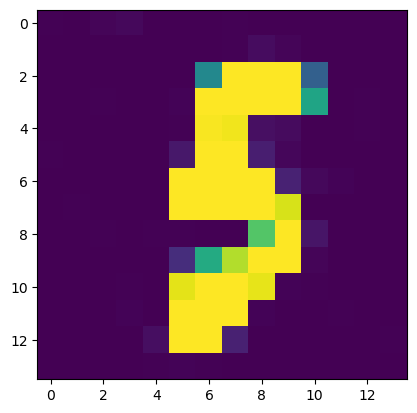

In [14]:
raw_lightning = raw_lightning.to(device=thickness.device)

raw_img_dist = dist.TransformedDistribution(
    dist.Normal(raw_lightning.base_loc, raw_lightning.base_scale).expand([raw_lightning.model.flat_input_size]).to_event(1),
    raw_lightning.model.condition(
        context=torch.cat([thickness[0:batch_size, None], intensity[0:batch_size, None]], dim=-1).log()
    ).inv)
raw_gen_img = raw_img_dist.sample((batch_size,)).reshape(-1, im_size, im_size)
print(raw_gen_img.max() - raw_gen_img.min())

plt.imshow(raw_gen_img[20].detach().cpu().numpy())
#plt.imshow(images[20].detach().cpu().numpy())

In [45]:
class DeepSCM(PyroModule):
    
    thickness_support = dist.constraints.positive
    intensity_support = dist.constraints.positive

    def __init__(
        self,
        thickness_transform: ThicknessTransform,
        intensity_transform: IntensityTransform,
        img_transform: ImageTransform,
        *,
        include_thickness: bool = True,
        include_intensity: bool = True,
        device: torch.device = curr_device,
    ):
        super().__init__()
        self.device = device
        self.include_thickness = include_thickness
        self.include_intensity = include_intensity
        
        self.thickness_transform = thickness_transform
        self.intensity_transform = intensity_transform
        self.img_transform = img_transform

        # tensor sizes
        self.thickness_size = self.thickness_transform.thickness_size
        self.intensity_size = self.intensity_transform.intensity_size
        self.im_size = self.img_transform.im_size
        self.input_dim = self.im_size * self.im_size

    @staticmethod
    def StandardNormal(*event_shape: int, **kwargs) -> Union[dist.Independent, dist.Normal]:
        return dist.Normal(
            torch.zeros((), **kwargs),
            torch.ones((), **kwargs),
        ).expand(event_shape).to_event(len(event_shape))
    
    @staticmethod
    def cond_dist(
        transform: Union[Transforms.Transform, dist.conditional.ConditionalTransform],
        U_dist: dist.Distribution,
        *contexts: torch.Tensor
    ) -> dist.Distribution:
        if not contexts:
            assert isinstance(transform, Transforms.Transform)
            return dist.TransformedDistribution(U_dist, transform)
        batch_shape = torch.broadcast_shapes(*(c.shape[:-1] for c in contexts))
        context = torch.cat([c.expand(batch_shape + (-1,)) for c in contexts], dim=-1)
        U_dist = U_dist.expand(torch.broadcast_shapes(batch_shape, U_dist.batch_shape))
        return dist.ConditionalTransformedDistribution(U_dist, [transform]).condition(context=context)

    def forward(self):
        # Thickness:
        UT_dist = self.StandardNormal(self.thickness_size, device=self.device)
        T_dist = self.cond_dist(self.thickness_transform, UT_dist)
        T = pyro.sample("T", T_dist.mask(self.include_thickness))
        T_unconstrained = Transforms.biject_to(self.thickness_support).inv(T)

        # Intensity:
        UI_dist = self.StandardNormal(self.intensity_size, device=self.device)
        I_dist = self.cond_dist(self.intensity_transform, UI_dist, T_unconstrained)
        I = pyro.sample("I", I_dist.mask(self.include_intensity))
        I_unconstrained = Transforms.biject_to(self.intensity_support).inv(I)

        # Image:
        UX_dist = self.StandardNormal(1, self.im_size, self.im_size, device=self.device)
        X_dist = self.cond_dist(self.img_transform, UX_dist, T_unconstrained, I_unconstrained)
        X = pyro.sample("X", X_dist)

        return X

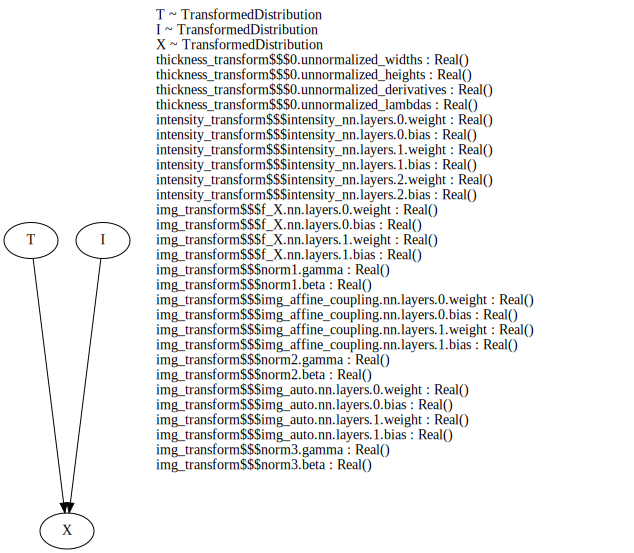

In [11]:
pyro.clear_param_store()
pyro.set_rng_seed(1234)

# Thickness parameters
thickness_size = 1
thickness_flow_bias = thickness.log().mean()
thickness_flow_weight = thickness.log().std()

thickness_transform = ThicknessTransform(
    thickness_size,
    thickness_flow_weight[..., None].detach(),
    thickness_flow_bias[..., None].detach()
)

# Intensity parameters
intensity_size = 1
intensity_hidden_dim = 5
intensity_flow_bias = intensity.min()
intensity_flow_weight = intensity.max() - intensity.min()

intensity_transform = IntensityTransform(
    intensity_size,
    thickness_size,
    [intensity_hidden_dim] * 2,
    intensity_flow_weight[..., None].detach(),
    intensity_flow_bias[..., None].detach()
)

# Image parameters
im_size = images.shape[-1]
input_dim = im_size ** 2
img_hidden_dim = 10
img_hidden_layers = 5
alpha = 0.05
num_bits = 8

img_transform = ImageTransform(
    im_size,
    input_dim,
    img_hidden_dim,
    img_hidden_layers,
    thickness_size,
    intensity_size,
    alpha=alpha,
    num_bits=num_bits,
    nonlinearity=torch.nn.ReLU(),
)

scm = DeepSCM(thickness_transform, intensity_transform, img_transform, include_thickness=False, include_intensity=False, device=curr_device)
pyro.render_model(scm, render_params=True, render_distributions=True)

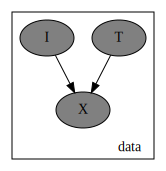

In [12]:
class ConditionedDeepSCM(PyroModule):
    def __init__(self, model: DeepSCM):
        super().__init__()
        self.model = model
        
    def forward(self, t_obs, i_obs, x_obs):
        with pyro.condition(data={"X": x_obs, "T": t_obs, "I": i_obs}), \
                pyro.poutine.scale(scale=1 / x_obs.shape[0]), \
                pyro.plate("data", size=x_obs.shape[0], dim=-1):
            return self.model()

conditioned_model = ConditionedDeepSCM(scm)
pyro.render_model(conditioned_model, model_args=(thickness[:5][..., None], intensity[:5][..., None], images[:5].reshape(-1, im_size*im_size)))

In [17]:
pyro.clear_param_store()

lr_decay = 0.99
initial_lr = 1e-5
adam_params = {"lr": initial_lr} #, "betas": (0.95, 0.999)}
batch_size = 256
num_epochs = 100

class LightningSVI(pl.LightningModule):
    def __init__(self, model: PyroModule, guide: PyroModule, elbo: pyro.infer.ELBO):
        super().__init__()
        self.model = model
        self.guide = guide
        self.elbo = elbo(self.model, self.guide)

    def training_step(self, batch, batch_idx):
        t_obs, i_obs, x_obs = batch
        loss = self.elbo(t_obs, i_obs, x_obs)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.elbo.parameters(), **adam_params)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)
        return [optimizer], [scheduler]

guide = pyro.infer.autoguide.AutoDelta(conditioned_model).to(device=curr_device)
elbo = pyro.infer.Trace_ELBO()
lightning_svi = LightningSVI(conditioned_model, guide, elbo).to(device=curr_device)

dataloader = DataLoader(
    torch.utils.data.TensorDataset(
        thickness[..., None].detach(),
        intensity[..., None].detach(),
        images.reshape(-1, images.shape[-1] ** 2).detach(),
    ),
    batch_size=batch_size,
    shuffle=True,
)

trainer = pl.Trainer(max_epochs=num_epochs, accelerator='gpu')
trainer.fit(model=lightning_svi, train_dataloaders=dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type               | Params
---------------------------------------------
0 | model | ConditionedDeepSCM | 1.7 M 
1 | guide | AutoDelta          | 0     
2 | elbo  | ELBOModule         | 1.7 M 
---------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.993     Total estimated model params size (MB)
/home/eli/development/causal_pyro/.env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/eli/development/causal_pyro/.env/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Automatic pdb calling has been turned OFF
tensor(62316704., device='cuda:0') tensor(-8755166., device='cuda:0')


(-0.5, 13.5, 13.5, -0.5)

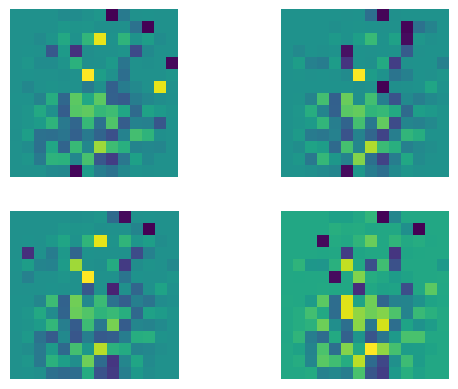

In [18]:
predictive = pyro.infer.Predictive(condition(scm, data = {"T": thickness[0:1][..., None], "I": intensity[0:1][..., None]}), guide=guide, num_samples=4)
img = predictive()["X"]
print((img[0] - img[1]).max(), (img[0] - img[1]).min())

fig = plt.figure()
rows = 2
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(img[0].cpu().reshape((im_size, im_size)))
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(img[1].cpu().reshape((im_size, im_size)))
plt.axis('off')
fig.add_subplot(rows, columns, 3)
plt.imshow(img[2].cpu().reshape((im_size, im_size)))
plt.axis('off')
fig.add_subplot(rows, columns, 4)
plt.imshow(img[3].cpu().reshape((im_size, im_size)))
plt.axis('off')

## Query: counterfactual data generation

Next we ask a *counterfactual* question: given an observed digit $X$, what
would the digit have been had $t$ been $t + 1$?

To compute this quantity we would normally:
   1. invert the model to find latent exogenous noise $u$
   2. construct an intervened model
   3. re-simulate the forward model on the $u$ [@pearl2011algorithmization].  

However, we can equivalently
represent this process with inference in a single, expanded
probabilistic program containing two copies of every deterministic
statement (a so-called \"twin network\" representation of
counterfactuals, first described in Chapter 7 of [@pearl] and extended
to the PPL setting in [@tavares_2020])

In [ ]:
x_obs = images[0]
plt.imshow(x_obs.cpu().detach().reshape((im_size, im_size)))

In [ ]:
class CounterfactualDeepSCM(PyroModule):
    def __init__(self, model: DeepSCM):
        super().__init__()
        self.model = model
        
    def forward(self, x_obs: torch.Tensor, i_act: torch.Tensor):
        with MultiWorldCounterfactual(dim=-1), \
                do(actions={"I": torch.tensor([190.0], device=x_obs.device)}), \
                condition(data={"X": x_obs}):
            return model()

cf_model = CounterfactualDeepSCM(scm)

In [ ]:
fig = plt.figure()
plt.title("Twin World Counterfactual Model")
plt.axis("off")
plt.tight_layout()
rows = 1
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(cf_model(x_obs)["X"][0][0].cpu().reshape((14, 14)))
plt.title("Actual Model")
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(torch.nn.functional.normalize(cf_model(x_obs)["X"][0][1].cpu().reshape((14, 14))))
plt.title("Intervened Model")
plt.axis('off')

Like all counterfactuals, this estimand is not identified in general
without further assumptions: learning parameters $\theta$ that match
observed data does not guarantee that the counterfactual distribution
will match that of the true causal model. 

However, as discussed in the
original paper [@pawlowski2020deep] in the context of modeling MRI
images, there are a number of valid practical reasons one might wish to
compute it anyway, such as explanation or expert evaluation.